# Potentiostat - Python API

This notebook was created and maintained by Robert Black

The following code is a basic notebook on how the potentiostat API will be integrated into our CCUS MAP. This will show:
a) How to use the potentiostat API to perform stand alone operation
b) How to integrate the potentiostat API with the CCUS MAP and considerations there-in

The following is a brief explanation of the various files used to operate the Biologic Potentiostat via python:

__Core Folder - _MultiChannel-Potentiostat-Management-Software___<br>
This folder stores the entire backend of the potentiostat, and general should not be touched or messed with unless you need to get into the 'guts' of the system. This includes important folders like the drivers, Techniques.py, Connection.py, and a wealth of information and examples from when this was developed. If planning to adjust any code in this folder, please contact Robert prior to doing so, and MAKE A BACKUP.

__PStatRun.py - the primary class and front-end interface to using the python API__<br>
This will be the primary class to call to start the potentistat. Within this class is the function __pstat_run(campaign_name, .json file)__ that is used to run the potentiostat, with the following inputs:<br>
_campaign_name - name of the experimental run, including the folder name to save_<br>
_master_runs_xxx.json file - the .json file that has the techniques and parameters to run for the potentiostat_<br>

__master_runs_xxx.json - potentiostat technique sequence / control file__ <br>
These .json files are used to feed the potentiostat the technique sequence and parameters.<br>
The name of the .json files are inputs to the __pstat_run__ function, and currently are labeled _'depo', 'char', 'perf', and 'custom'_.

Below is a .jpeg to show the relationship between these files:
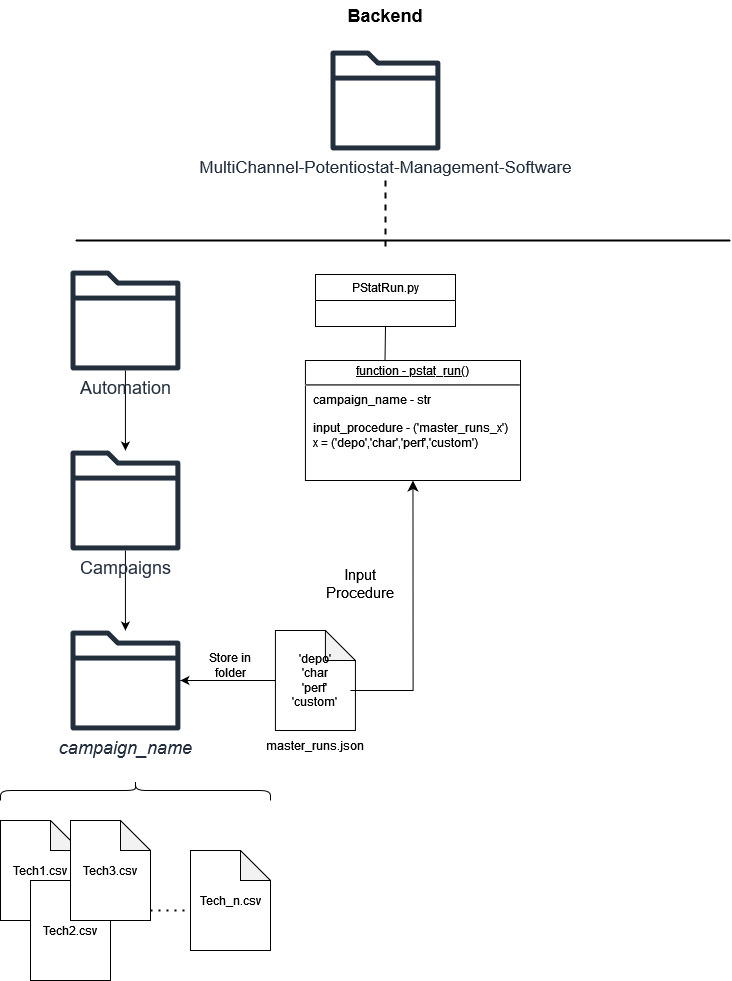

## 0. Preparing to operate the potentiostat API

Explain some important information from the PStatRun.py that has to be updated prior to use, to ensure connection and proper pathing

The following code is found in the __PStatRun.py__ file, under the function __pstat_run()__ that has to be updated should the potentiostat code be used on another computer. The configuration below is for the __EME_Lab__ computer used for the CCUS MAP. This needs to be updated in the __PStatRun.py__ and saved before use.

In [ ]:
address = "192.168.1.25"  # address of the device in use - can be ethernet or 'USB0' if plugged in via USB. 

# This must point to the Core folder MultiChannel-Potentiostat-Management-Software
binary_path = "C:\\Users\\nrc-eme-lab\\Desktop\\Automation\\MultiChannel-Potentiostat-Management-Software\\EC_Lab_Development_Package_2022\\EC-Lab Development Package\\"  # address for dev package
api, id_, device_info = connect(address, binary_path)  # connect to the device
    
# The following folder will be the same folder as the .pkl file created during the workflow. It will use campaign_name input
# as part of the pstat_run() function
save_loc = f'C:/Users/nrc-eme-lab/Desktop/Automation/Campaigns/{campaign_name}/' # main folder where the data will be saved
if not os.path.exists(save_loc): # Check if folder exists - if not, make it, else use existing folder
   os.makedirs(save_loc)

## 1. How to run the Potentiostat as a stand alone experiment

1. Make a custom .json file and name it 'master_runs_custom'. Update the .json file accordingly to populate experimental name, making sure the status is set as 'incomplete'
2. Make a subfolder in the 'Campaign' folder with the same experimental ID identified in the json file
3. Add the .json file from number 1 into the subfolder from number 2
4. Run the following code

In [ ]:
from PStatRun import pstat_run

campaign_name = 'rbnb3pxxx' # replace with the specific campaign name to be run
pstat_run(campaign_name, 'custom')

Upon execution, you should immeditely see the firmware load and the instrument connet, followed by the potentiostat running the procedure defined in the .json file

The data will be saved as .csv files in the specified folder, in the following format per each technique defined within the .json experimental file:<br><br>
__Test_(num)_(ch)_(technique)_(order number).csv__<br><br>
_eg.Test_30_ch3_CV_4.csv_

## 2. How to run the Potentiostat as part of the CCUS MAP

The following shows how to integrate the potentiostat into the CCUS MAP workflow

1. The script below is used to initiate the CCUS campaign. This generates the campaign name folder (unless it already exists), and creates the empty campaign .pkl file that will be populated as experiments are run.

In [ ]:
# This block sets up the initial dictionary as part of the campaign. This is the object that will be updated throughout each run
campaign_name = 'rbnb3pxx'
number_runs = 50
exp_start = 0 # 0 is new campaign, other if continuing an existing campaign
dict = {}
dict[f'{campaign_name}'] = {}

#Pre populate the dictionary with the general data structure
for exp_count in range(number_runs):
    dict[f'{campaign_name}'][f'Test_{exp_count}'] = {'Depo':{},'Char':{},'Metric':{},'AL':{}}

# Create the folder if it doesn't exist based on the date of creation
date_format = date.today().strftime("%Y_%m_%d") # https://www.programiz.com/python-programming/datetime/current-datetime
root_path = f'C:/Users/Blackr/Documents/CCUS/MAPs/Initiate/{date_format}/' #Update to your own path

if not os.path.exists(root_path): # Check if folder exists - if not, make it, else use existing folder
    os.makedirs(root_path)

# # Save the initial pickle file
with open(f'{root_path}{campaign_name}_saved_data.pkl', 'wb') as f:
            pickle.dump(dict, f)

2. Generate and populate the 'depo', 'char', and 'perf' .json experimental files to be used in the campaign<br>
3. Make a subfolder in the 'Campaign' folder with the same experimental ID identified in the json file
4. Add the .json file from number 21 into the subfolder from number 3
5. Run the following code

In [ ]:
from PStatRun import pstat_run

campaign_name = 'rbnb3pxxx' # replace with the specific campaign name to be run
pstat_run(campaign_name, 'depo') #Run the .json of your choice

6. Once the campaign is complete, run the following post-processing algorithm to automatically parse the information from the .csv files into the .pkl file

In [5]:
'''
Developed by Robert Black:
The following code is used to curate and process the data for the CCUS MAP. In particular, this post-processing algorithm
is for the WGC project.

This is split into two parts - the first part is curation of the data from electrochem excel files to the global project pickle file

The second part is to curate the data into 'metric' data that will be used for the optimization and/or process the data into
useful pieces
'''

class PostProcessing:
    def __init__(self,root_path,campaign_name,test): # add in the rootpath here
	# Have the class initialization create and load the .json file as a dictionary?
            self.root_path = root_path
            self.campaign_name = campaign_name
            self.test = test

    def curate_deposition(self): #pickle_file will be the overall name of the pickle file
        global loaded_data # Want to have the variable outside of the function
        # import in the empty pickle file that already exists
        with open(f'{self.root_path}{self.campaign_name}_saved_data.pkl', 'rb') as file:
            loaded_data = pickle.load(file)

        # Import each excel file and put all the data into the dictionary
        df = pd.read_csv(f'{self.root_path}{self.test}_ch1_OCV_1.csv', header = 14) #REPLACE WITH ACTUAL TEST NAME

        ocv_data = {}
        for column in df.columns:
            ocv_data[column] = df[column].to_list()
            loaded_data[f'{self.campaign_name}'][f'{self.test}']['Depo']['OCV'] = ocv_data
        
        df = pd.read_csv(f'{self.root_path}{self.test}_ch1_PEIS_2.csv', header = 29) #REPLACE WITH ACTUAL TEST NAME
        
        peis_data = {}
        for column in df.columns:
            peis_data[column] = df[column].to_list()
            loaded_data[f'{self.campaign_name}'][f'{self.test}']['Depo']['PEIS'] = peis_data

        df = pd.read_csv(f'{self.root_path}{self.test}_ch1_CA_3.csv', header = 19) #REPLACE WITH ACTUAL TEST NAME

        ca_data = {}
        for column in df.columns:
            ca_data[column] = df[column].to_list()
            loaded_data[f'{self.campaign_name}'][f'{self.test}']['Depo']['CA'] = ca_data
       
        # Save the pickle file
        with open(f'{self.root_path}{self.campaign_name}_saved_data.pkl', 'wb') as file:
            pickle.dump(loaded_data, file)
        
        return loaded_data

    def curate_characterization(self):
        global loaded_data # Want to have the variable outside of the function
        # import in the empty pickle file that already exists
        with open(f'{self.root_path}{self.campaign_name}_saved_data.pkl', 'rb') as file:
            loaded_data = pickle.load(file)

        # Import each excel file and put all the data into the dictionary
        df = pd.read_csv(f'{self.root_path}{self.test}_ch2_OCV_1.csv', header = 14) #REPLACE WITH ACTUAL TEST NAME

        ocv_data = {}
        for column in df.columns:
            ocv_data[column] = df[column].to_list()
            loaded_data[f'{self.campaign_name}'][f'{self.test}']['Char']['OCV'] = ocv_data

        df = pd.read_csv(f'{self.root_path}{self.test}_ch2_PEIS_2.csv', header = 29) #REPLACE WITH ACTUAL TEST NAME

        peis_data = {}
        for column in df.columns:
            peis_data[column] = df[column].to_list()
            loaded_data[f'{self.campaign_name}'][f'{self.test}']['Char']['PEIS'] = peis_data

        for i in [3,4,5,6,7,8]:
            df = pd.read_csv(f'{self.root_path}{self.test}_ch2_CV_{i}.csv', header = 22) #REPLACE WITH ACTUAL TEST NAME
            cv_data = {}
            for column in df.columns:
                cv_data[column] = df[column].to_list()
                loaded_data[f'{self.campaign_name}'][f'{self.test}']['Char'][f'CV_{i}'] = cv_data
       
        # Save the pickle file
        with open(f'{self.root_path}{self.campaign_name}_saved_data.pkl', 'wb') as file:
            pickle.dump(loaded_data, file)
        
        return loaded_data
    
    #def curate_performance(self):
    #To be updated once we firm up our performance metrics

In [ ]:
#Example below:
root_path = 'C:/Users/nrc-eme-lab/Desktop/Automation/Campaigns/2023_07_11/'
campaign_name = 'rbnb3p86'
test = 'Test_1'
process_data = PostProcessing(root_path, campaign_name, test)

7. Post-processing of the data into metric data

In [ ]:
# TODO